In [133]:
import cooler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
import h5py
import pickle
import seaborn as sns
import tqdm


import sys
import itertools
import time

sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')
from __init__ import *
from __init__jupyterlab import * 
import snmcseq_utils

In [2]:
default_colorbar_kws = DEFAULT_COLORBAR_KWS

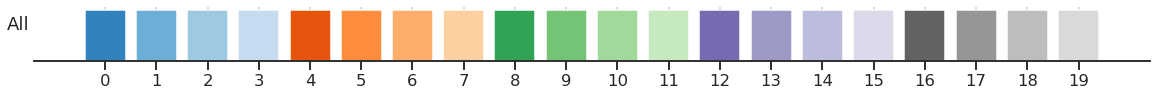

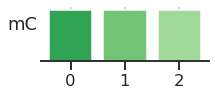

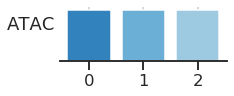

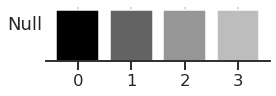

In [117]:
# color palette
cm = plt.cm.tab20c.colors

# settle down on a color palette
colors_mc = [cm[8], cm[9], cm[10],]
colors_atac = [cm[0], cm[1], cm[2],]
colors_null = ['black', cm[16], cm[17], cm[18],]

color_tracks = [
    cm,
    colors_mc,
    colors_atac,
    colors_null,
]

labels = [
    'All',
    'mC',
    'ATAC',
    'Null',
]

for color_track, label in zip(color_tracks, labels):
    n = len(color_track)
    fig, ax = plt.subplots(figsize=(1*n,1))
    ax.bar(np.arange(n), 1, 
           color=color_track)
    ax.set_xticks(np.arange(n))
    ax.set_ylabel(label, rotation=0, ha='right')
    sns.despine(ax=ax, left=True)
    ax.set_yticks([])
    plt.show()

In [118]:
mod_palette = {
    'mc': 'C2',
    'atac': 'C0',
    'null': 'k',
}

mod_palette_comp = {
    'mc': colors_mc,
    'atac': colors_atac,
    'null': colors_null,
}


KB = 1000
def p25(x):
    return np.percentile(x, 25)
def p75(x):
    return np.percentile(x, 75)


In [3]:
# L2/3 cell types contacts
# with h5py.File('/cndd2/Public_Datasets/m3c_Lee_etal_2019/L2_3_all_brain.txt_1kb_contacts.mcool') as f:
    
f = h5py.File('/cndd2/Public_Datasets/m3c_Lee_etal_2019/L2_3_all_brain.txt_1kb_contacts.mcool')
print(
    list(f.keys()), 
    list(f['resolutions']),
    list(f['resolutions']['1000'].keys()), 
)

# pick one resolution 
resolution = 5000
print(str(resolution))
mycooler = cooler.Cooler(f['resolutions'][str(resolution)])

['resolutions'] ['1000', '10000', '100000', '1000000', '10000000', '2000', '20000', '200000', '2000000', '20000000', '40000', '5000', '50000', '500000', '5000000'] ['bins', 'chroms', 'indexes', 'pixels']
5000


# example of plot contact_bins

In [4]:
with open('./hic_from_ethan/data/plot_examples.pkl', 'rb') as fh:
    enh_genes_plot = pickle.load(fh)
    
# type(enh_genes_plot)
# # print(enh_genes_plot.shape)
# # enh_genes_plot.head()
# enh_genes_plot
print(len(enh_genes_plot), list(enh_genes_plot.keys())[:5])

enh_genes_plot['ENSMUSG00000000440']

169 ['ENSMUSG00000000440', 'ENSMUSG00000000531', 'ENSMUSG00000001985', 'ENSMUSG00000005089', 'ENSMUSG00000005102']


,chrom,start,end,annot
104006,chr3,12199199,12200057,191527
12981,chr3,12287798,12287799,ENSMUSG00000000440


5000 22
chr3:12,189,199-12,297,798 (23, 23)


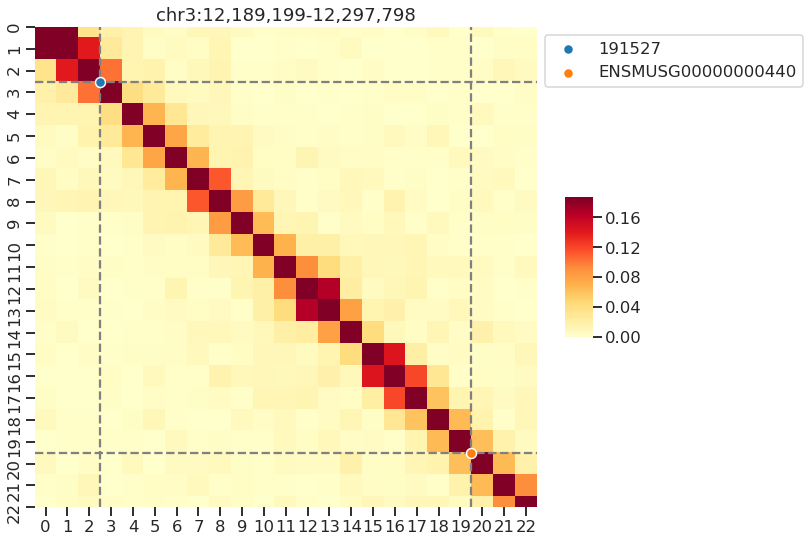

In [5]:
cooler = mycooler
bins_annot = enh_genes_plot['ENSMUSG00000000440']
num_bins_flank = 2

# query
chrom, start, end = (
    bins_annot.iloc[0,0], bins_annot['start'].min(), bins_annot['start'].max()
)

# get cooler binsize
binsize = cooler.binsize
num_bins = int((end-start+binsize)/binsize) + num_bins_flank*2
print(binsize, num_bins)

# get region
query = "{}:{:,}-{:,}".format(chrom, start-num_bins_flank*binsize, end+num_bins_flank*binsize)
mat = cooler.matrix(balance=True).fetch(query)
print(query, mat.shape)
max_diag = np.max(np.diag(mat))
max_offdiag = np.max(np.triu(mat, k=1)) 

# plot 
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(
            mat,
            cmap='YlOrRd',
            cbar_kws={'fraction': 0.05, 'shrink': 0.4, 'aspect': 5},
            vmax=max_offdiag,
            ax=ax,
           )
ax.set_aspect('equal')
ax.set_title(query)
for idx, row in bins_annot.iterrows():
    idx_pos = int((row['start'] - start + binsize)/binsize) + num_bins_flank
    
    ax.axhline(idx_pos, color='gray', linestyle='--', zorder=1)
    ax.axvline(idx_pos, color='gray', linestyle='--', zorder=1)
    ax.scatter(idx_pos, idx_pos, 
               label=row['annot'], 
               edgecolors='white',
               s=100,
               zorder=2,
              )
ax.legend(bbox_to_anchor=(1,1), loc='upper left')

plt.show()

# contact frequencies as a function of genomic distance 

In [8]:
def kth_diag_indices(n, k=0):
    """
    """
    assert k >= 0
    
    row_idx = np.arange(n)
    col_idx = np.arange(n)
    
    col_idx = row_idx + k
    
    if k > 0:
        return row_idx[:-k], col_idx[:-k]
    if k == 0:
        return row_idx, col_idx

def mat_values_kth_diag_indices(mat, k=0):
    """
    """
    return mat[kth_diag_indices(len(mat), k=k)]

In [6]:
# 
chromosome = 'chr1'
celltype = 'L2/3'

mat_all = cooler.matrix(balance=True).fetch(chromosome)

In [9]:

mat = mat_all 
distance_cutoff = 1e6

contacts_mean = []
contacts_std = []
distance_idx = np.arange(1, int(distance_cutoff/resolution))
distances = distance_idx * resolution
for i in distance_idx:
    contacts = mat_values_kth_diag_indices(mat, k=i)
    contacts_mean.append(np.nanmean(contacts)) 
    contacts_std.append(np.nanstd(contacts)) 
    
contacts_mean = np.array(contacts_mean)
contacts_std = np.array(contacts_std)

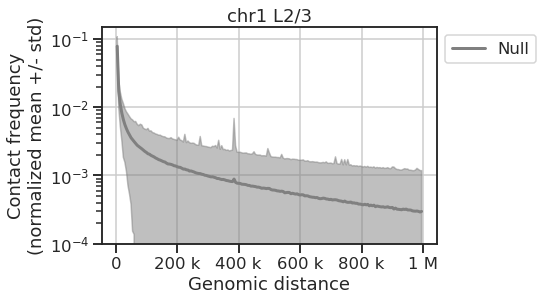

In [10]:
fig, ax = plt.subplots()
_x, _y, _yerr = distances, contacts_mean, contacts_std
color='gray'

ax.plot(_x, _y, '-', color=color, linewidth=3, label='Null')
ax.fill_between(_x, _y-_yerr, _y+_yerr, color=color, alpha=0.5)

ax.xaxis.set_major_formatter(mtick.EngFormatter())
ax.set_xlabel('Genomic distance')
ax.set_ylabel('Contact frequency\n(normalized mean +/- std)')
ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_title("{} {}".format(chromosome, celltype))

ax.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.show()

# Contact frequency of any enhancer-gene pairs

In [11]:
# enhancers lifted
f = './hic_from_ethan/enhancers_lifted.bed'
enh_list = pd.read_csv(f, sep='\t', header=None, names=['chr', 'start', 'end', 'enh_id'])
enh_list['center'] = (enh_list['start'] + enh_list['end'])/2
print(enh_list.shape)
enh_list.head()

# tss lifted
f = './hic_from_ethan/tss_lifted.bed'
tss_list = pd.read_csv(f, sep='\t', header=None, names=['chr', 'start', 'end', 'gid'])
print(tss_list.shape)
tss_list.head()

# enh - tss linked list


(126134, 5)
(33814, 4)


,chr,start,end,gid
0,chr8,55102323,55102324,ENSMUSG00000051951
1,chr4,83273518,83273519,ENSMUSG00000102851
2,chr8,55409874,55409875,ENSMUSG00000103377
3,chr8,55288183,55288184,ENSMUSG00000089699
4,chr8,55230212,55230213,ENSMUSG00000103201


In [93]:
ti = time.time()

# all pairs of enh and gene within distance cutoff (1Mb)
enhs = enh_list[enh_list['chr']=='chr1']
tsss = tss_list[tss_list['chr']=='chr1']

# bins
enh_bins = np.sort((enhs['center'].values/resolution).astype(int))
tsss_bins = np.sort((tsss['start'].values/resolution).astype(int))
print(enhs.shape, tsss.shape)

# comb bins
combs = np.array(list(itertools.product(enh_bins, tsss_bins)))
combs_df = pd.DataFrame()
combs_df['enh_bin'] = combs[:,0]
combs_df['gene_bin'] = combs[:,1]
combs_df['dist_bin'] = np.abs(combs_df['enh_bin'] - combs_df['gene_bin'])
combs_df = combs_df[combs_df['dist_bin']<=int(distance_cutoff/resolution)]
combs_df = combs_df.set_index('dist_bin')
print(combs_df.shape)

print(time.time()-ti)

(11010, 5) (3378, 4)
(317833, 2)
21.923168420791626


In [94]:

mat = mat_all 
    
distance_cutoff = 1e6
distance_idx = np.arange(1, int(distance_cutoff/resolution))
distances = distance_idx * resolution

contacts_mean = []
contacts_std = []

contacts_pairs_mean = []
contacts_pairs_std = []

for i in tqdm.tqdm(distance_idx):
    contacts = mat_values_kth_diag_indices(mat, k=i)
    
    try:
        pairs = combs_df.loc[i]
        contacts_pairs = mat[(pairs['enh_bin'].values, 
                              pairs['gene_bin'].values, 
                             )]
    except:
        contact_pairs = []
    
    
    contacts_mean.append(np.nanmean(contacts)) 
    contacts_std.append(np.nanstd(contacts)) 
    
    contacts_pairs_mean.append(np.nanmean(contacts_pairs)) 
    contacts_pairs_std.append(np.nanstd(contacts_pairs)) 
    
contacts_mean = np.array(contacts_mean)
contacts_std = np.array(contacts_std)

contacts_pairs_mean = np.array(contacts_pairs_mean)
contacts_pairs_std = np.array(contacts_pairs_std)

100%|██████████| 199/199 [00:00<00:00, 231.56it/s]


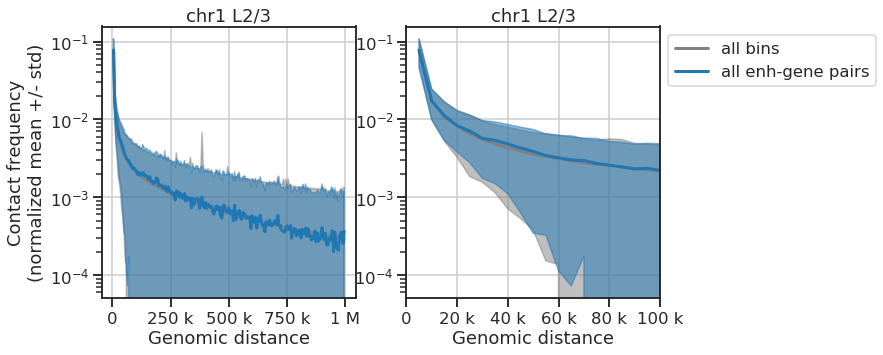

In [95]:
fig, axs = plt.subplots(1, 2, figsize=(5*2,5))

for i, ax in enumerate(axs):
    _x, _y, _yerr = distances, contacts_mean, contacts_std
    color='gray'
    ax.plot(_x, _y, '-', color=color, linewidth=3, label='all bins')
    ax.fill_between(_x, _y-_yerr, _y+_yerr, color=color, alpha=0.5)

    _x, _y, _yerr = distances, contacts_pairs_mean, contacts_pairs_std
    color='C0'
    ax.plot(_x, _y, '-', color=color, linewidth=3, label='all enh-gene pairs')
    ax.fill_between(_x, _y-_yerr, _y+_yerr, color=color, alpha=0.5)

    ax.xaxis.set_major_formatter(mtick.EngFormatter())
    ax.set_yscale('log')
    ax.set_xlabel('Genomic distance')
    ax.set_title("{} {}".format(chromosome, celltype))
    
    if i == 0:
        ax.set_ylabel('Contact frequency\n(normalized mean +/- std)')

ax.set_xlim([0, 1e5])
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.show()

# Contact frequency of correlated and linked enhancer-gene pairs

In [150]:
def enh_gene_id_to_binidx(_table, resolution):
    """
    Given a dataframe of enh-gene pairs (by IDs)
    return which bins in HiC data they correspond to
    
    Return a dataframe with dist_bin as index, 'gene_bin', 'enh_bin' as columns
    """
    # merge gid, enh_id with genome locations
    _tmp = pd.merge(_table, tsss.rename(columns={'chr': 'gene_chr',
                                                 'start': 'gene_start',
                                                 'end': 'gene_end',
                                                 'gid': 'gene',
                                                }), on='gene')

    _tmp = pd.merge(_tmp, enhs.rename(columns={'chr': 'enh_chr',
                                               'start': 'enh_start',
                                               'end': 'enh_end',
                                               'center': 'enh_center',
                                               'enh_id': 'enh',
                                              }), on='enh')
    # find the correct bins
    _tmp['enh_bin'] = (_tmp['enh_center'].values/resolution).astype(int)
    _tmp['gene_bin'] = (_tmp['gene_start'].values/resolution).astype(int)
    _tmp['dist_bin'] = np.abs(_tmp['enh_bin'] - _tmp['gene_bin'])
    _tmp = _tmp.set_index('dist_bin')
    
    return _tmp

In [75]:
# # original enhancer index
# f = ('/cndd2/fangming/projects/scf_enhancers/scripts/scf_enhancer_paper'
#      '/hic/hic_from_ethan/data/enhancer_bed.bed'
#     )
# enhs_orig = pd.read_csv(f, sep='\t').rename(columns={
#     '0': 'chr', '1': 'start', '2': 'end', '4': 'index'
#     })
# print(enhs_orig.shape)
# enhs_orig.head()


(233524, 4)


,chr,start,end,index
0,chr1,3083769,3083816,0
1,chr1,3112234,3112467,1
2,chr1,3112770,3112986,2
3,chr1,3113717,3114035,3
4,chr1,3118790,3118935,4


In [103]:
# orig significant pairs (enh_index and gid)

# load some results
f = '/sphere/fangming/enhancers/scripts/results_new/fig2_201027_linked_pairs_mc.tsv'
linked_pairs_mc = pd.read_csv(f, sep="\t")
print(linked_pairs_mc.shape)

f = '/sphere/fangming/enhancers/scripts/results_new/fig2_201027_linked_pairs_atac.tsv'
linked_pairs_atac = pd.read_csv(f, sep="\t")
print(linked_pairs_atac.shape)

f = '/sphere/fangming/enhancers/scripts/results_new/fig2_201027_correlated_pairs_mc.tsv'
correlated_pairs_mc = pd.read_csv(f, sep="\t")
print(correlated_pairs_mc.shape)

f = '/sphere/fangming/enhancers/scripts/results_new/fig2_201027_correlated_pairs_atac.tsv'
correlated_pairs_atac = pd.read_csv(f, sep="\t")
print(correlated_pairs_atac.shape)

linked_pairs_mc.head()

(7455, 3)
(3879, 3)
(85596, 3)
(50012, 3)


,gene,enh,dist
0,ENSMUSG00000000058,181997,14555
1,ENSMUSG00000000088,221978,48225
2,ENSMUSG00000000126,35942,90017
3,ENSMUSG00000000126,35953,4552
4,ENSMUSG00000000126,35954,5567


In [140]:
# assuming this enhancer id is the same as the one ethan used
linked_pairs_mc_bin = enh_gene_id_to_binidx(linked_pairs_mc, resolution)
linked_pairs_atac_bin = enh_gene_id_to_binidx(linked_pairs_atac, resolution)
correlated_pairs_mc_bin = enh_gene_id_to_binidx(correlated_pairs_mc, resolution)
correlated_pairs_atac_bin = enh_gene_id_to_binidx(correlated_pairs_atac, resolution)

paired_bin_tables = collections.OrderedDict({
    'linked_mc': linked_pairs_mc_bin,
    'linked_atac': linked_pairs_atac_bin,
    'correlated_mc': correlated_pairs_mc_bin,
    'correlated_atac': correlated_pairs_atac_bin,
})
track_names = list(paired_bin_tables.keys())
colors = [
    mod_palette_comp['mc'][0],
    mod_palette_comp['atac'][0],
    mod_palette_comp['mc'][2],
    mod_palette_comp['atac'][2],
]

In [111]:

mat = mat_all 
    
distance_cutoff = 1e6
distance_idx = np.arange(1, int(distance_cutoff/resolution))
distances = distance_idx * resolution

contacts_mean = []
contacts_std = []

contacts_pairs_mean = []
contacts_pairs_std = []

contacts_sig_pairs_mean = collections.OrderedDict({_label: [] for _label, _table in paired_bin_tables.items()})
contacts_sig_pairs_std = collections.OrderedDict({_label: [] for _label, _table in paired_bin_tables.items()})

for i in tqdm.tqdm(distance_idx):
    contacts = mat_values_kth_diag_indices(mat, k=i)
    contacts_mean.append(np.nanmean(contacts)) 
    contacts_std.append(np.nanstd(contacts)) 
    
    try:
        pairs = combs_df.loc[i]
        contacts_pairs = mat[(pairs['enh_bin'].values, 
                              pairs['gene_bin'].values, 
                             )]
    except:
        contacts_pairs = []
    contacts_pairs_mean.append(np.nanmean(contacts_pairs)) 
    contacts_pairs_std.append(np.nanstd(contacts_pairs)) 
    
    for _label, _table in paired_bin_tables.items():
        try:
            pairs = _table.loc[i]
            contacts_sig_pairs = mat[(pairs['enh_bin'].values, pairs['gene_bin'].values)]
        except:
            contacts_sig_pairs = []
        
        contacts_sig_pairs_mean[_label].append(np.nanmean(contacts_sig_pairs)) 
        contacts_sig_pairs_std[_label].append(np.nanstd(contacts_sig_pairs)) 
    
    
contacts_mean = np.array(contacts_mean)
contacts_std = np.array(contacts_std)

contacts_pairs_mean = np.array(contacts_pairs_mean)
contacts_pairs_std = np.array(contacts_pairs_std)

contacts_sig_pairs_mean = collections.OrderedDict({
                _label: np.array(_table) for _label, _table in contacts_sig_pairs_mean.items()})
contacts_sig_pairs_std = collections.OrderedDict({
                _label: np.array(_table) for _label, _table in contacts_sig_pairs_std.items()})

  5%|▍         | 9/199 [00:00<00:02, 84.64it/s]/cndd2/fangming/venvs/hic_py3p6/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice
/cndd2/fangming/venvs/hic_py3p6/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
100%|██████████| 199/199 [00:01<00:00, 135.27it/s]


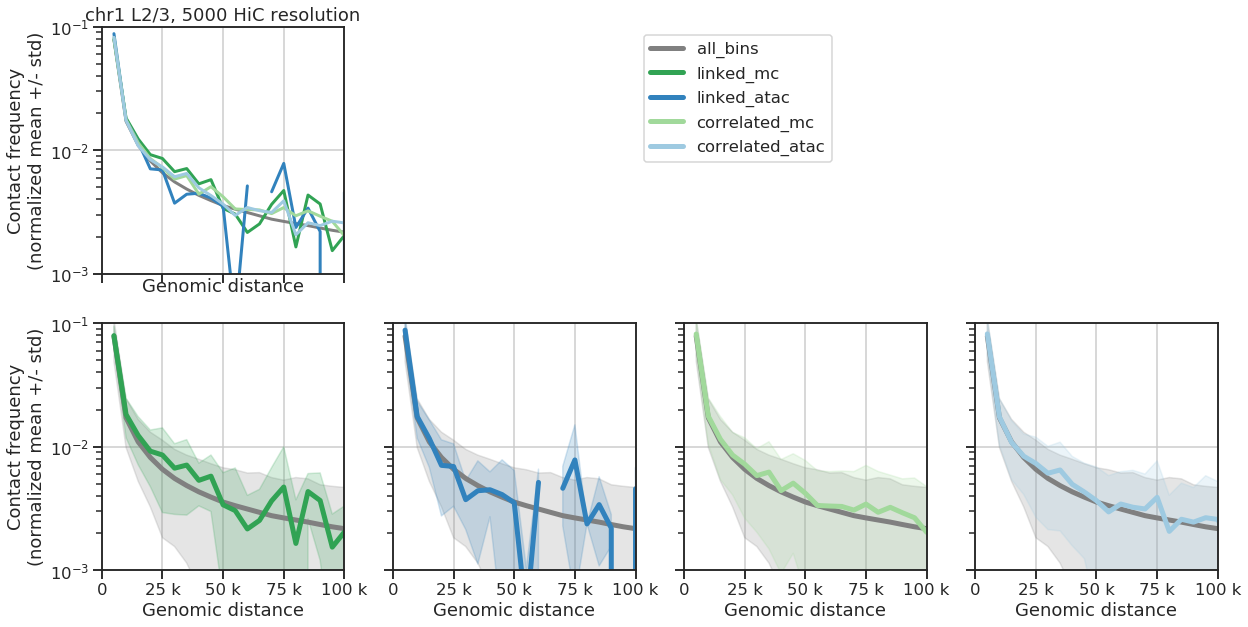

In [153]:
fig, axs = plt.subplots(2, 4, figsize=(5*4,5*2), sharey=True, sharex=True)

ax = axs[0,0]
_x, _y, _yerr = distances, contacts_mean, contacts_std
color='gray'
ax.plot(_x, _y, '-', color=color, linewidth=3, label='all_bins')
#     ax.fill_between(_x, _y-_yerr, _y+_yerr, color=color, alpha=0.5)
for i, (_name, _color) in enumerate(zip(track_names, colors)):
    _x, _y, _yerr = distances, contacts_sig_pairs_mean[_name], contacts_sig_pairs_std[_name]
    ax.plot(_x, _y, '-', color=_color, linewidth=3, label=_name)
#     ax.fill_between(_x, _y-_yerr, _y+_yerr, color=_color, alpha=0.5)
ax.xaxis.set_major_formatter(mtick.EngFormatter())
ax.set_yscale('log')
ax.set_xlabel('Genomic distance')
ax.set_xlim([0, 1e5])
ax.set_ylim([1e-3, 1e-1])
ax.set_ylabel('Contact frequency\n(normalized mean +/- std)')
ax.set_title("{} {}, {} HiC resolution".format(chromosome, celltype, resolution))

for ax in axs[0,1:]:
    ax.axis('off')

for i, (ax, _name, _color) in enumerate(zip(axs[1], track_names, colors)):
    _x, _y, _yerr = distances, contacts_mean, contacts_std
    color='gray'
    ax.fill_between(_x, _y-_yerr, _y+_yerr, color=color, alpha=0.2)
    ax.plot(_x, _y, '-', color=color, linewidth=5, label='all_bins', alpha=1)

    _x, _y, _yerr = distances, contacts_sig_pairs_mean[_name], contacts_sig_pairs_std[_name]
    ax.fill_between(_x, _y-_yerr, _y+_yerr, color=_color, alpha=0.2)
    ax.plot(_x, _y, '-', color=_color, linewidth=5, label=_name, alpha=1)
    
    ax.xaxis.set_major_formatter(mtick.EngFormatter())
    ax.set_yscale('log')
    ax.set_xlabel('Genomic distance')
#     ax.set_title("{} {}".format(chromosome, celltype))
    ax.set_xlim([0, 1e5])
    ax.set_ylim([1e-3, 1e-1])
    
    if i == 0:
        ax.set_ylabel('Contact frequency\n(normalized mean +/- std)')

handles, labels = snmcseq_utils.combine_legends(axs.flat)
handles, labels = snmcseq_utils.dedup_legends(handles, labels)
axs[0,1].legend(handles, labels, bbox_to_anchor=(1,1), loc='upper left')
plt.show()

# apply this to different HiC map resolutions, chromosomes, cell types

Todo: 
- make sure the enhancer indices are correct 
- make sure the HiC map indices are correct

In [ ]:
chromosome = 'chr1'
celltype = 'L2/3'

f = h5py.File('/cndd2/Public_Datasets/m3c_Lee_etal_2019/L2_3_all_brain.txt_1kb_contacts.mcool')
print(
    list(f.keys()), 
    list(f['resolutions']),
    list(f['resolutions']['1000'].keys()), 
)

# pick one resolution 
resolution = 5000
print(str(resolution))
mycooler = cooler.Cooler(f['resolutions'][str(resolution)])

# mat_all = cooler.matrix(balance=True).fetch(chromosome)